# HT 5. Validación Cruzada

## Predicción de calidad de vinos en base a características físico-químicas

**MINERÍA DE DATOS - SECCIÓN - 20 - 2024 - 1**

Samuel Chamalé, 21881

Renatto Guzmán, 21646

---


## 1. Exploración y Preprocesamiento de Datos


### Cargar el conjunto de datos utilizando Pandas.


In [345]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from ydata_profiling import ProfileReport

In [346]:
%matplotlib inline

In [347]:
# Cargar los datos de vinos rojos y blancos
path_red = "wine+quality/winequality-red.csv"
path_white = "wine+quality/winequality-white.csv"

In [348]:
# Asumimos que el separador en los archivos CSV es ';'
red_wine = pd.read_csv(path_red, sep=';')
white_wine = pd.read_csv(path_white, sep=';')

In [349]:
# Combinar los datasets añadiendo una columna de 'type'
red_wine['type'] = 'red'
white_wine['type'] = 'white'
wine_data = pd.concat([red_wine, white_wine], ignore_index=True)

### Análisis exploratorio de datos (EDA) básico: estadísticas descriptivas, distribución de variables, etc.


In [350]:
# Estadísticas descriptivas
print(wine_data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    6497.000000       6497.000000  6497.000000     6497.000000   
mean        7.215307          0.339666     0.318633        5.443235   
std         1.296434          0.164636     0.145318        4.757804   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.400000          0.230000     0.250000        1.800000   
50%         7.000000          0.290000     0.310000        3.000000   
75%         7.700000          0.400000     0.390000        8.100000   
max        15.900000          1.580000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  6497.000000          6497.000000           6497.000000  6497.000000   
mean      0.056034            30.525319            115.744574     0.994697   
std       0.035034            17.749400             56.521855     0.002999   
min       0.009000             1.000000         

In [351]:
# Perfilamiento automático de datos usando ydata_profiling
# profile = ProfileReport(wine_data, title="Wine Quality Data Report")
# profile.to_file("wine_quality_report.html")

### Ver reporte de perfil en:

[wine_quality_report.html](./wine_quality_report.html)


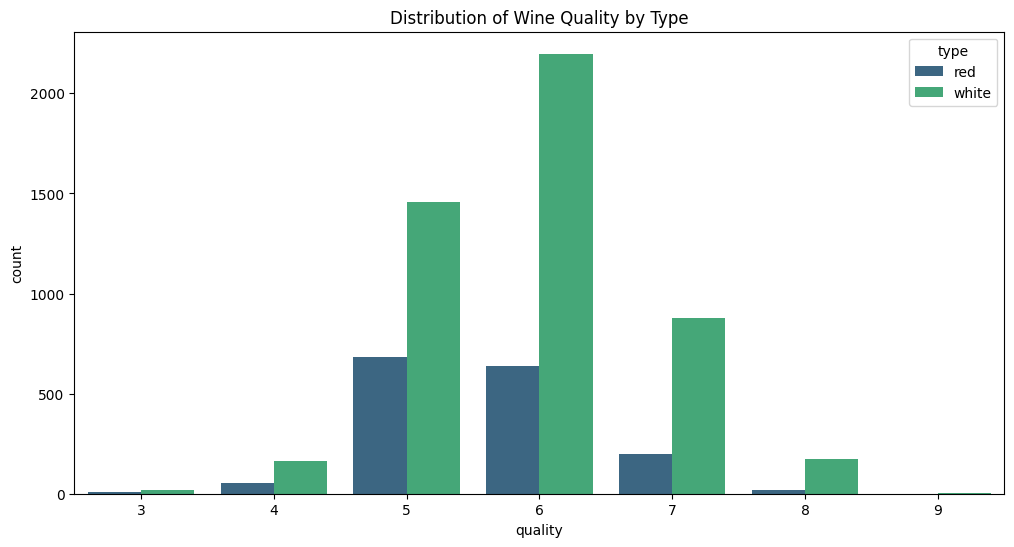

In [352]:
# Distribución de las variables
plt.figure(figsize=(12, 6))
sns.countplot(x='quality', data=wine_data, hue='type', palette='viridis')
plt.title('Distribution of Wine Quality by Type')
plt.show()

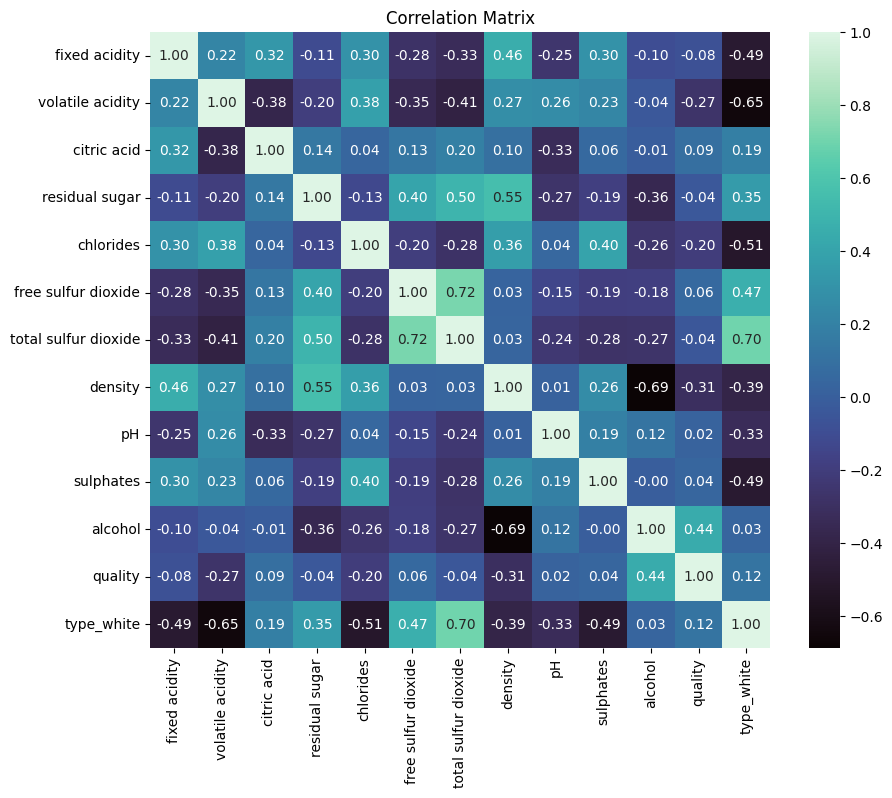

In [353]:
# Now you can plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(pd.get_dummies(wine_data, drop_first=True).corr(),
            annot=True, fmt=".2f", cmap='mako')
plt.title('Correlation Matrix')
plt.show()

### Preprocesar los datos: limpieza, tratamiento de valores faltantes, normalización/estandarización si es necesario.


In [354]:
# Normalizamos todas las variables numéricas excepto 'quality'
from sklearn.preprocessing import StandardScaler

features = wine_data.columns.difference(['quality', 'type'])
scaler = StandardScaler()
wine_data[features] = scaler.fit_transform(wine_data[features])

In [355]:
# Visualización interactiva de la relación entre alcohol y calidad
fig = px.scatter(wine_data, x='alcohol', y='quality',
                 color='type', trendline='ols')
fig.show()

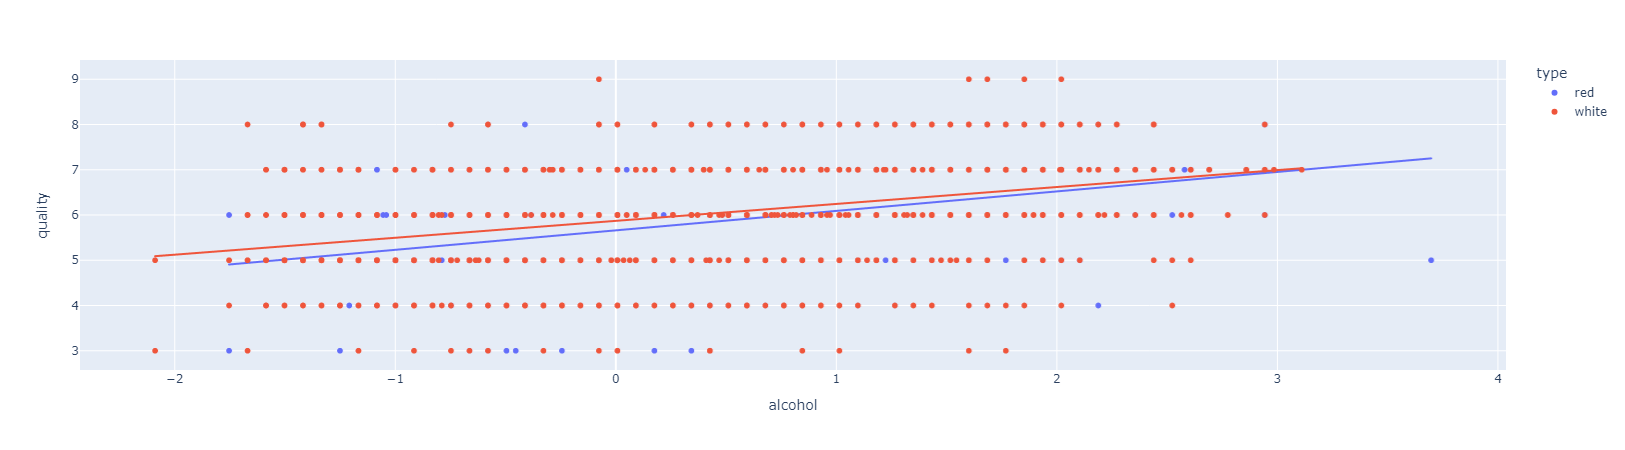


## Insights de EDA


1. **Duplicados en los Datos**: Hay un 15.3% de filas duplicadas en el conjunto de datos. Esto podría influir en el desempeño de los modelos de aprendizaje automático y podría ser indicativo de problemas en la recopilación de datos o de entrada de datos. **Sin embargo**, es interesante notar que el número más alto de duplicados para una sola entrada es 8. Esto podría sugerir varias posibilidades. Como:
   - Proceso de Fabricación Estándar: La vinificación podría seguir protocolos estándar para ciertos tipos de vino, resultando en lotes con características químicas idénticas. Esto es plausible si los datos provienen de producciones industralizadas donde la consistencia es clave. Sin embargo no tenemos certeza de esta información.
   - Granularidad de los Datos: Los instruments utilizados para medir las variables tiene una resolución limitada. Tristemente no tenemos información acerca de las herramientas y procesos de medición utilizados.
   - Coincidencia: Dado que las características fisicoquímicas se miden en rangos limitados, la posibilidad de coincidencia en los valores exactos entre diferentes muestras no es nula.

La pregunta verdadera es **¿Qué hacemos con estos datos?** Si tuviesemos acceso a más información podríamos plantear preguntas como: ¿Los duplicados pertenecen a lotes de producción tomados en el mismo periodo de tiempo? ¿Existe alguna razón operativa por la cual los valores medidos podrían ser idénticos? ¿La distribución de otras variables no incluidas en el conjunto de datos (como la marca del vino o la región de producción) sugiere alguna agrupación que justifique los duplicados?

2. **Correlaciones Significativas**:
   - La acidez fija está fuertemente correlacionada con el tipo de vino. Esto puede deberse a que los vinos rojos y blancos se producen con diferentes procesos y tipos de uvas, que naturalmente tienen distintos niveles de acidez fija.
   - La acidez volátil también muestra una fuerte correlación con el tipo de vino, lo que puede afectar el sabor y la estabilidad del vino.
   - El azúcar residual está altamente correlacionado con la densidad, lo cual es esperado ya que los azúcares incrementan la densidad de los líquidos.
   - Los cloruros, que contribuyen a la salinidad del vino, tienen una alta correlación con la densidad.
   - El dióxido de azufre libre y el total están fuertemente correlacionados, lo que sugiere que los procesos que afectan uno probablemente afectan al otro.
   - El alcohol está altamente correlacionado negativamente con la densidad, lo que se espera ya que la fermentación convierte el azúcar en alcohol, reduciendo la densidad del vino.
3. **Distribución de la Calidad del Vino**: La mayoría de los vinos tienen una calidad calificada entre 5 y 6. Hay menos vinos con calificaciones bajas (3, 4) y altas (7, 8, 9), lo que indica una distribución sesgada hacia los vinos de calidad media.

4. **Variables con Ceros**: El ácido cítrico tiene un 2.3% de valores cero. Esto podría ser debido a que algunos vinos no requieren la adición de ácido cítrico en su proceso de fabricación.

5. **Variabilidad en los Datos**: Hay una amplia gama de valores en varias variables, como el azúcar residual y el dióxido de azufre, lo que indica una gran diversidad en los procesos de vinificación y las características del vino.

6. **Datos Estadísticos Clave**:
   - El alcohol varía considerablemente de 8% a casi 15%, lo que puede tener un impacto significativo en la percepción sensorial y por lo tanto en la calidad.
   - La calidad del vino varía entre 3 y 9, con una media cercana a 6, lo que podría indicar que hay más vinos de calidad media en el conjunto de datos.

**\*Análisis de comportamientos químicos realizado con ayuda de ChatGPT (soy machacador, no experto...) :)**


## Acciones a tomar en base a los Insights


Con el objetivo de desarrollar un modelo predictivo robusto y preciso para la calidad del vino basado en sus propiedades físico-químicas, se ha decidido proceder con la eliminación de duplicados del conjunto de datos. Esta decisión se justifica por varias razones clave.

Primero, la presencia de un 15% de duplicados en un conjunto de datos de 6497 observaciones sugiere una repetición significativa que podría sesgar nuestros modelos de aprendizaje automático, como la Regresión Logística, KNN y Random Forest, especialmente si estos duplicados no representan una variabilidad genuina en los procesos de vinificación.

Segundo, la integridad del conjunto de datos no se ve comprometida por la ausencia de valores faltantes, lo que facilita la toma de esta decisión sin el riesgo de perder información crítica.

Además, la eliminación de duplicados tiene el potencial de mejorar la generalización de los modelos al evitar el sobreajuste, una consideración vital dado que se empleará la validación cruzada para evaluar el rendimiento de los modelos. Por último, la amplia cantidad de datos aún disponibles tras la eliminación de duplicados asegura que habrá suficiente información para entrenar y validar los modelos de manera efectiva, lo cual es esencial para alcanzar el objetivo de predecir con precisión la calidad del vino.


In [356]:
# Comprobar el número de datos antes y después de eliminar duplicados
print(f"Número de datos antes de eliminar duplicados: {wine_data.shape[0]}")

Número de datos antes de eliminar duplicados: 6497


In [357]:
# Eliminamos las filas duplicadas manteniendo la primera aparición
wine_data.drop_duplicates(inplace=True, keep='first')

In [358]:
print(f"Número de datos después de eliminar duplicados: {wine_data.shape[0]}")

Número de datos después de eliminar duplicados: 5320


In [359]:
# Variable categórica 'type' a numérica usando one-hot encoding
wine_data = pd.get_dummies(wine_data, drop_first=True)

In [360]:
# Guardar el conjunto de datos procesado
wine_data.to_csv('processed_wine_quality.csv', index=False)

## 2. División del Conjunto de Datos


### Dividir el conjunto de datos en entrenamiento y prueba utilizando una proporción 80-20.


In [361]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el conjunto de datos limpio y preprocesado
wine_data = pd.read_csv('processed_wine_quality.csv')

# Separar las variables independientes (X) de la variable dependiente (y)
X = wine_data.drop('quality', axis=1)  # todas las columnas excepto 'quality'
y = wine_data['quality']               # la columna 'quality'

# Dividir el conjunto de datos en entrenamiento y prueba (80% entrenamiento, 20% prueba)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

# Verificar las dimensiones de los conjuntos resultantes
print(f'Conjunto de entrenamiento: {X_train.shape[0]} muestras')
print(f'Conjunto de prueba: {X_test.shape[0]} muestras')

Conjunto de entrenamiento: 4256 muestras
Conjunto de prueba: 1064 muestras


## 3. & 4. Selección y Entrenamiento de Modelos & Validación Cruzada


A continuación voy a crear un pipeline para cada modelo con PCA para reducción de dimensionalidad y GridSearchCV para ajuste de hiperparámetros.


In [362]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [363]:
# Definir un pipeline para la Regresión Logística
pipeline_lr = Pipeline([
    ('pca', PCA()),
    # aumentar el número de iteraciones, por defecto es 100 pero no converge en este caso
    ('clf', LogisticRegression(max_iter=1000))
])

# Hiperparámetros para la Regresión Logística
params_lr = {
    'pca__n_components': [None, 0.95, 0.9],
    'clf__C': [0.01, 0.1, 1, 10, 100]
}

In [364]:
# Definir un pipeline para KNN
pipeline_knn = Pipeline([
    ('pca', PCA()),
    ('clf', KNeighborsClassifier())
])

# Hiperparámetros para KNN
params_knn = {
    'pca__n_components': [None, 0.95, 0.9],
    'clf__n_neighbors': [3, 5, 7, 9]
}

In [365]:
# Definir un pipeline para Random Forest
pipeline_rf = Pipeline([
    ('pca', PCA()),
    ('clf', RandomForestClassifier())
])

# Hiperparámetros para Random Forest
params_rf = {
    'pca__n_components': [None, 0.95, 0.9],
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 5, 10, 15]
}

In [366]:
# Realizar Grid Search para cada modelo usando StratifiedKFold
grid_search_lr = GridSearchCV(pipeline_lr, params_lr, cv=4)
grid_search_knn = GridSearchCV(pipeline_knn, params_knn, cv=4)
grid_search_rf = GridSearchCV(pipeline_rf, params_rf, cv=4)

In [367]:
# Entrenar cada modelo usando el conjunto de entrenamiento
print("Entrenando modelos...")

grid_search_lr.fit(X_train, y_train)
print("Regresión Logística entrenada.")

grid_search_knn.fit(X_train, y_train)
print("KNN entrenado.")

grid_search_rf.fit(X_train, y_train)
print("Random Forest entrenado.")

# Obtener los mejores hiperparámetros y scores de cada modelo
print("\nMejores parámetros y score para Regresión Logística:")
print(grid_search_lr.best_params_)
print(grid_search_lr.best_score_)

print("\nMejores parámetros y score para KNN:")
print(grid_search_knn.best_params_)
print(grid_search_knn.best_score_)

print("\nMejores parámetros y score para Random Forest:")
print(grid_search_rf.best_params_)
print(grid_search_rf.best_score_)

# Asignar los mejores modelos a una variable
best_lr = grid_search_lr.best_estimator_
best_knn = grid_search_knn.best_estimator_
best_rf = grid_search_rf.best_estimator_

Entrenando modelos...
Regresión Logística entrenada.
KNN entrenado.
Random Forest entrenado.

Mejores parámetros y score para Regresión Logística:
{'clf__C': 1, 'pca__n_components': None}
0.5488721804511278

Mejores parámetros y score para KNN:
{'clf__n_neighbors': 9, 'pca__n_components': None}
0.5300751879699248

Mejores parámetros y score para Random Forest:
{'clf__max_depth': 15, 'clf__n_estimators': 200, 'pca__n_components': None}
0.5697838345864662


### Resumen de Resultados de Selección y Entrenamiento de Modelos utilizando GridSearchCV


**1. Regresión Logística**

- **Mejores Parámetros**:
  - `C=1`: Este parámetro controla la regularización en la Regresión Logística. Un valor de `C` más alto significa menos regularización, lo que sugiere que el modelo está tratando de ajustarse bien a los datos, sin necesidad de restringirse tanto para evitar el sobreajuste.
  - `pca__n_components=None`: Indica que no se utilizó reducción de dimensionalidad mediante PCA (Principal Component Analysis) antes de aplicar la regresión. Esto sugiere que mantener todas las características originales proporcionó los mejores resultados para este modelo.
- **Mejor Score**: 54.88%. Este es el mejor puntaje de precisión alcanzado durante la validación cruzada, lo que indica que el modelo tiene una capacidad del 54.89% de predecir correctamente la calidad del vino en nuevos datos, bajo el ajuste de parámetros dado.

**2. KNN (K-Nearest Neighbors)**

- **Mejores Parámetros**:
  - `n_neighbors=9`: El modelo encontró que usar 9 vecinos cercanos proporciona la mejor precisión. Esto implica que considerar 9 muestras más cercanas en el espacio de características ayuda a realizar predicciones más precisas para este conjunto de datos.
  - `pca__n_components=None`: Al igual que en la Regresión Logística, no se aplicó reducción de dimensionalidad, lo que indica que las características completas son necesarias para obtener la mejor predicción con KNN.
- **Mejor Score**: 53.00%. Este score refleja la precisión media obtenida en la validación cruzada, que es la técnica utilizada para evaluar cómo el modelo KNN generalizaría a un conjunto de datos independiente.

**3. Random Forest**

- **Mejores Parámetros**:
  - `max_depth=15`: Una profundidad máxima de 15 para los árboles en el bosque indica un equilibrio entre aprender suficientemente los datos y no caer en el sobreajuste.
  - `n_estimators=200`: Usar 200 árboles en el ensamble del bosque aleatorio proporciona la mejor precisión, lo que sugiere que un número mayor de árboles contribuye a una mejor generalización.
  - `pca__n_components=None`: La ausencia de PCA sugiere que la reducción de la dimensionalidad no es beneficiosa para el modelo de Random Forest con este conjunto de datos.
- **Mejor Score**: 56.93%. Este es el puntaje más alto de los tres modelos, lo que indica que el modelo de Random Forest fue capaz de aprender mejor los patrones en los datos para predecir la calidad del vino, bajo la configuración de hiperparámetros óptima encontrada.


In [368]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate, StratifiedKFold
import numpy as np

In [369]:
# Hiperparámetros y modelos
models_params = {
    'Logistic Regression': {
        'pipeline': Pipeline([
            ('pca', PCA()),
            ('clf', LogisticRegression(max_iter=1000))
        ]),
        'params': {
            'pca__n_components': [None, 0.95, 0.9],
            'clf__C': [0.01, 0.1, 1, 10, 100]
        }
    },
    'KNN': {
        'pipeline': Pipeline([
            ('pca', PCA()),
            ('clf', KNeighborsClassifier())
        ]),
        'params': {
            'pca__n_components': [None, 0.95, 0.9],
            'clf__n_neighbors': [3, 5, 7, 9]
        }
    },
    'Random Forest': {
        'pipeline': Pipeline([
            ('pca', PCA()),
            ('clf', RandomForestClassifier())
        ]),
        'params': {
            'pca__n_components': [None, 0.95, 0.9],
            'clf__n_estimators': [50, 100, 200],
            'clf__max_depth': [None, 5, 10, 15]
        }
    }
}

In [370]:
results = {}
cv = StratifiedKFold(n_splits=4)

for model_name, config in models_params.items():
    model_results = []
    for n_components in config['params']['pca__n_components']:
        for param, values in config['params'].items():
            if param == 'pca__n_components':
                continue
            for value in values:
                # Configuración del modelo
                config['pipeline'].set_params(
                    **{'pca__n_components': n_components, param: value})
                # Validación cruzada
                scores = cross_validate(
                    config['pipeline'], X_train, y_train, cv=cv, scoring='accuracy', return_train_score=True)
                model_results.append(
                    {'Params': {'pca__n_components': n_components, param: value}, 'Scores': scores})
    results[model_name] = model_results

# Imprimir resultados
for model_name, model_results in results.items():
    print(f"\nModelo: {model_name}")
    for result in model_results:
        print(f"Parámetros: {result['Params']}, Score promedio: {np.mean(result['Scores']['test_score'])}, Score de entrenamiento promedio: {np.mean(result['Scores']['train_score'])}")


Modelo: Logistic Regression
Parámetros: {'pca__n_components': None, 'clf__C': 0.01}, Score promedio: 0.5451127819548872, Score de entrenamiento promedio: 0.5461309523809523
Parámetros: {'pca__n_components': None, 'clf__C': 0.1}, Score promedio: 0.5484022556390977, Score de entrenamiento promedio: 0.550516917293233
Parámetros: {'pca__n_components': None, 'clf__C': 1}, Score promedio: 0.5488721804511278, Score de entrenamiento promedio: 0.5513001253132832
Parámetros: {'pca__n_components': None, 'clf__C': 10}, Score promedio: 0.5469924812030076, Score de entrenamiento promedio: 0.5516134085213033
Parámetros: {'pca__n_components': None, 'clf__C': 100}, Score promedio: 0.5465225563909775, Score de entrenamiento promedio: 0.5516134085213034
Parámetros: {'pca__n_components': 0.95, 'clf__C': 0.01}, Score promedio: 0.5462875939849624, Score de entrenamiento promedio: 0.5450344611528822
Parámetros: {'pca__n_components': 0.95, 'clf__C': 0.1}, Score promedio: 0.5469924812030075, Score de entrenam

# Interpretación de Resultados y Conclusión


### Interpretación final de Resultados

De los resultados obtenidos mediante `GridSearchCV` y `cross_validate`, se observa lo siguiente:

- **Random Forest** demostró el mejor desempeño general con un score promedio de validación de aproximadamente 0.57. Sin embargo, mostró señales claras de sobreajuste (Score promedio < Score de entrenamiento promedio), con scores de entrenamiento cercanos o iguales a 1.0. Este sobreajuste indica que el modelo aprendió demasiado de los detalles del conjunto de entrenamiento, comprometiendo su capacidad de generalizar a nuevos datos.
- **Regresión Logística** mostró un desempeño moderado con el mejor score de validación de aproximadamente 0.55. La diferencia entre los scores de entrenamiento y validación fue mínima, lo que sugiere un buen equilibrio en la capacidad de generalización del modelo.
- **KNN** tuvo el rendimiento más bajo con el mejor score de validación cerca de 0.53. Además, mostró un significativo sobreajuste especialmente con menos vecinos, indicando que el modelo se ajustó demasiado a los datos de entrenamiento.

### Conclusión

Dado el análisis de los resultados:

- **Random Forest** fue el mejor modelo en términos de precisión de validación. No obstante, su tendencia al sobreajuste necesita ser controlada mediante ajustes en los parámetros del modelo, como la profundidad máxima del árbol y el número de características a considerar en cada división.
- **Regresión Logística** ofreció un buen compromiso entre precisión y capacidad de generalización, y podría ser una buena elección si la prioridad es tener un modelo menos complejo y más interpretable.
- **KNN** mostró el menor rendimiento, lo cual podría deberse a la naturaleza de los datos y posiblemente a la necesidad de un escalado adecuado de las características o la exploración de diferentes métricas de distancia.


### Visualizaciones de Datos y Resultados


#### Características más importantes según el modelo Random Forest entrenado con los mejores parámetros del GridSearchCV


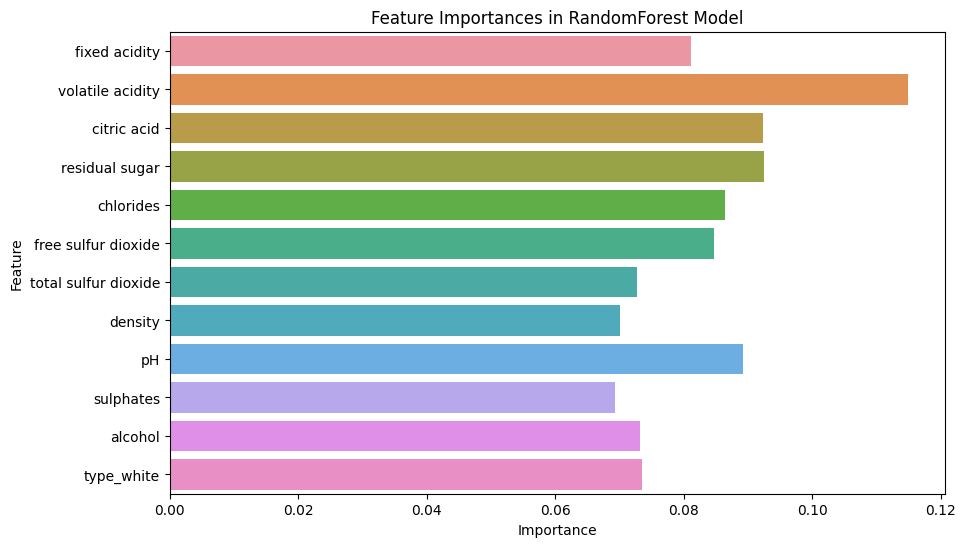

In [371]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

# Suponiendo que X_train e y_train ya están definidos y son tus datos de entrenamiento
pipeline_rf = Pipeline([
    ('pca', PCA()),  # pca__n_components es None, por lo que no reducimos la dimensionalidad
    ('clf', RandomForestClassifier(max_depth=15, n_estimators=200))
])

# Entrenar el modelo
pipeline_rf.fit(X_train, y_train)

# Obtener las características más importantes
feature_importances = pipeline_rf.named_steps['clf'].feature_importances_
# Asegúrate de que X_train sea un DataFrame para que esto funcione
features = X_train.columns

# Crear gráfico
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=features, orient='h')
plt.title('Feature Importances in RandomForest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

### Sugerencias para Mejoras Futuras

1. **Experimentar sin la Eliminación de Duplicados**: Considerar la no eliminación de duplicados en el conjunto de datos y evaluar cómo afecta esto al rendimiento de los modelos.
2. **Optimización de Hiperparámetros Adicionales**: Para Random Forest, explorar más a fondo la regulación de parámetros como `min_samples_split` y `min_samples_leaf`.
3. **Análisis Más Profundo de Características**: Realizar un análisis más detallado de las características para identificar y posiblemente crear nuevas características que puedan mejorar la predicción. (Feature Engineering, algo no visto a profundidad durante clase)
4. **Selección Datos**: Si es posible, utilizar utilizar el conjunto de datos para vinos rojos y blancos por separado.
